In [1]:
import tensorflow as tf
import timesynth as ts
import numpy as np
from tqdm import tqdm
import timeflow as tflow
import matplotlib.pylab as plt
import statsmodels.api as sm
%matplotlib inline

#### Generating real world dataset

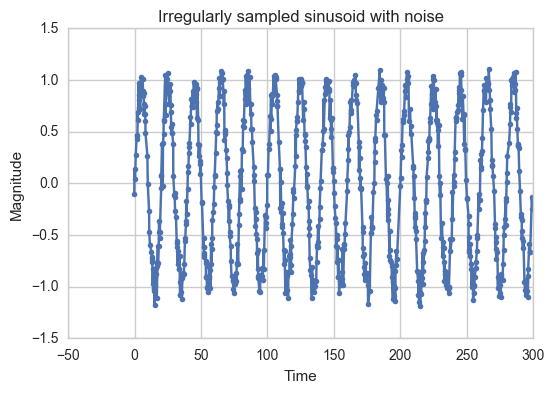

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=300)
#Sampling regular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=1000, keep_percentage=80)
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.05)
#Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.1)
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)
#Plotting the series
plt.plot(irregular_time_samples, samples, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Irregularly sampled sinusoid with noise')

In [3]:
num_training_points = 250
num_validation_points = 250
X = np.stack([samples[:-1], np.diff(irregular_time_samples)]).T
Y = np.reshape(samples[1:], (len(samples[1:]), 1))
X_train = X[:num_training_points, :]
Y_train = Y[:num_training_points]
X_valid = X[num_training_points:num_training_points+num_validation_points, :]
Y_valid = Y[num_training_points:num_training_points+num_validation_points, :]
X_test = X[num_training_points+num_validation_points:, :]
Y_test = Y[num_training_points+num_validation_points:, :]
time_vector = irregular_time_samples[1:]

#### Buidling the connected network

In [4]:
input_size = 2
hidden_size = 50
output_size = 1

In [5]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_placeholder(input_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
with tf.variable_scope('Regression_Layer'):
    reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)
with tf.variable_scope('Output'):
    output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer)
    outputs = output_layer.get_outputs()
with tf.variable_scope('Y'):
    y = tflow.placeholders.prediction.output_placeholder(output_size)
# Initializing the autocorr initilization and munging
with tf.variable_scope('data_for_acr'):
    acr_init = tflow.utils.autocorr.AutoCorrInitializer(inputs, outputs, y)
    time_diff_residual, sign_res = acr_init.create_tensor_output()
# Initializing the autocorrelation graph solver
with tf.variable_scope('ACR_Solver'):
    auto_corr_obj = tflow.utils.autocorr.AutoCorr(time_diff_residual, sign_res)

#### Generating step for training autocorrelation network

In [6]:
log_likelihood = auto_corr_obj.generate_log_loss()
#Additional loss term
multiplier = 2
add_loss_phi = tf.exp(tf.pow(multiplier*(auto_corr_obj.phi_tf-1), 3)) + \
               tf.exp(tf.pow(multiplier*(-auto_corr_obj.phi_tf), 3))
adjusted_loss = log_likelihood + add_loss_phi
optacr = tf.train.AdamOptimizer(learning_rate=0.01)
scopes = ['ACR_Solver']
tr_list = []
for scope in scopes:
    tr_list = tr_list + tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
train_step = optacr.minimize(adjusted_loss, var_list=tr_list)

#### Generating training step for main LSTM network

In [7]:
reg_parameter = 10.0
with tf.variable_scope('RMSE'):
    rmse = tflow.utils.metrics.RMSE(outputs, y)
    loss_func = tflow.utils.metrics.RMSE(outputs, y) + reg_parameter*tf.square(auto_corr_obj.phi_tf)
scopes_net = ['Input', 'Input_LSTM_Layer', 'LSTM_Layer', 'Regression_Layer', 'Output']
tr_list_net = []
for scope in scopes_net:
    tr_list_net = tr_list_net + tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
opt_main = tf.train.RMSPropOptimizer(learning_rate=0.05)
train_step_main = opt_main.minimize(loss_func, var_list=tr_list_net)

#### Starting training

In [8]:
# Starting tensorflow session
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
n_iterations = 60
for i in range(n_iterations):
    if (i+1)%5 == 0:
        samples = np.random.normal(loc=0.5, scale=0.01, size=2)
        assign_op = auto_corr_obj.phi_tf.assign([samples[0]])
        assign_op2 = auto_corr_obj.sigma_tf.assign([samples[1]])
        sess.run([assign_op, assign_op2])
        print "Resetting phi and sigma"
    prev_score = 1e8
    _, computed_score = sess.run([train_step, adjusted_loss],
                                        feed_dict={inputs: X_train,
                                                   y: Y_train})
    while (np.abs(prev_score - computed_score) > 1e-5):
        prev_score  = computed_score
        _, score, computed_score = sess.run([train_step, log_likelihood, adjusted_loss],
                                                 feed_dict={inputs: X_train,
                                                            y: Y_train})
    
    phi_value, sigma_value = sess.run([auto_corr_obj.phi_tf[0], auto_corr_obj.sigma_tf[0]])
    #Training the model on the new cost function
    sess.run(train_step_main, feed_dict={inputs: X_train,
                                        y: Y_train})
    train_rmse_score, loss_ = sess.run([rmse, loss_func], feed_dict={inputs: X_train,
                                        y: Y_train})
    valid_rmse_score, valid_loss_ = sess.run([rmse, loss_func], feed_dict={inputs: X_valid,
                                        y: Y_valid})
    test_rmse_score, test_loss_ = sess.run([rmse, loss_func], feed_dict={inputs: X_test,
                                        y: Y_test})
    
    # Printing for visual logs
    print "Parameter values for iteration %d : phi = %f   sigma = %f" %(i+1, phi_value, sigma_value)
    print "Scores for iteration %d : train_rmse = %f   valid_rmse = %f  train_loss = %f valid_loss = %f"\
            %(i+1, train_rmse_score, valid_rmse_score, loss_, valid_loss_)

Parameter values for iteration 1 : phi = 0.859203   sigma = 0.701132
Scores for iteration 1 : train_rmse = 0.500410   valid_rmse = 0.465150  train_loss = 7.882710 valid_loss = 7.847450
Parameter values for iteration 2 : phi = 0.866380   sigma = 0.721055
Scores for iteration 2 : train_rmse = 0.500150   valid_rmse = 0.465534  train_loss = 8.006292 valid_loss = 7.971676
Parameter values for iteration 3 : phi = 0.866383   sigma = 0.721063
Scores for iteration 3 : train_rmse = 0.499920   valid_rmse = 0.465908  train_loss = 8.006115 valid_loss = 7.972103
Parameter values for iteration 4 : phi = 0.866353   sigma = 0.720983
Scores for iteration 4 : train_rmse = 0.499716   valid_rmse = 0.466267  train_loss = 8.005386 valid_loss = 7.971936
Resetting phi and sigma
Parameter values for iteration 5 : phi = 0.866265   sigma = 0.720735
Scores for iteration 5 : train_rmse = 0.499534   valid_rmse = 0.466605  train_loss = 8.003693 valid_loss = 7.970764
Parameter values for iteration 6 : phi = 0.866129  

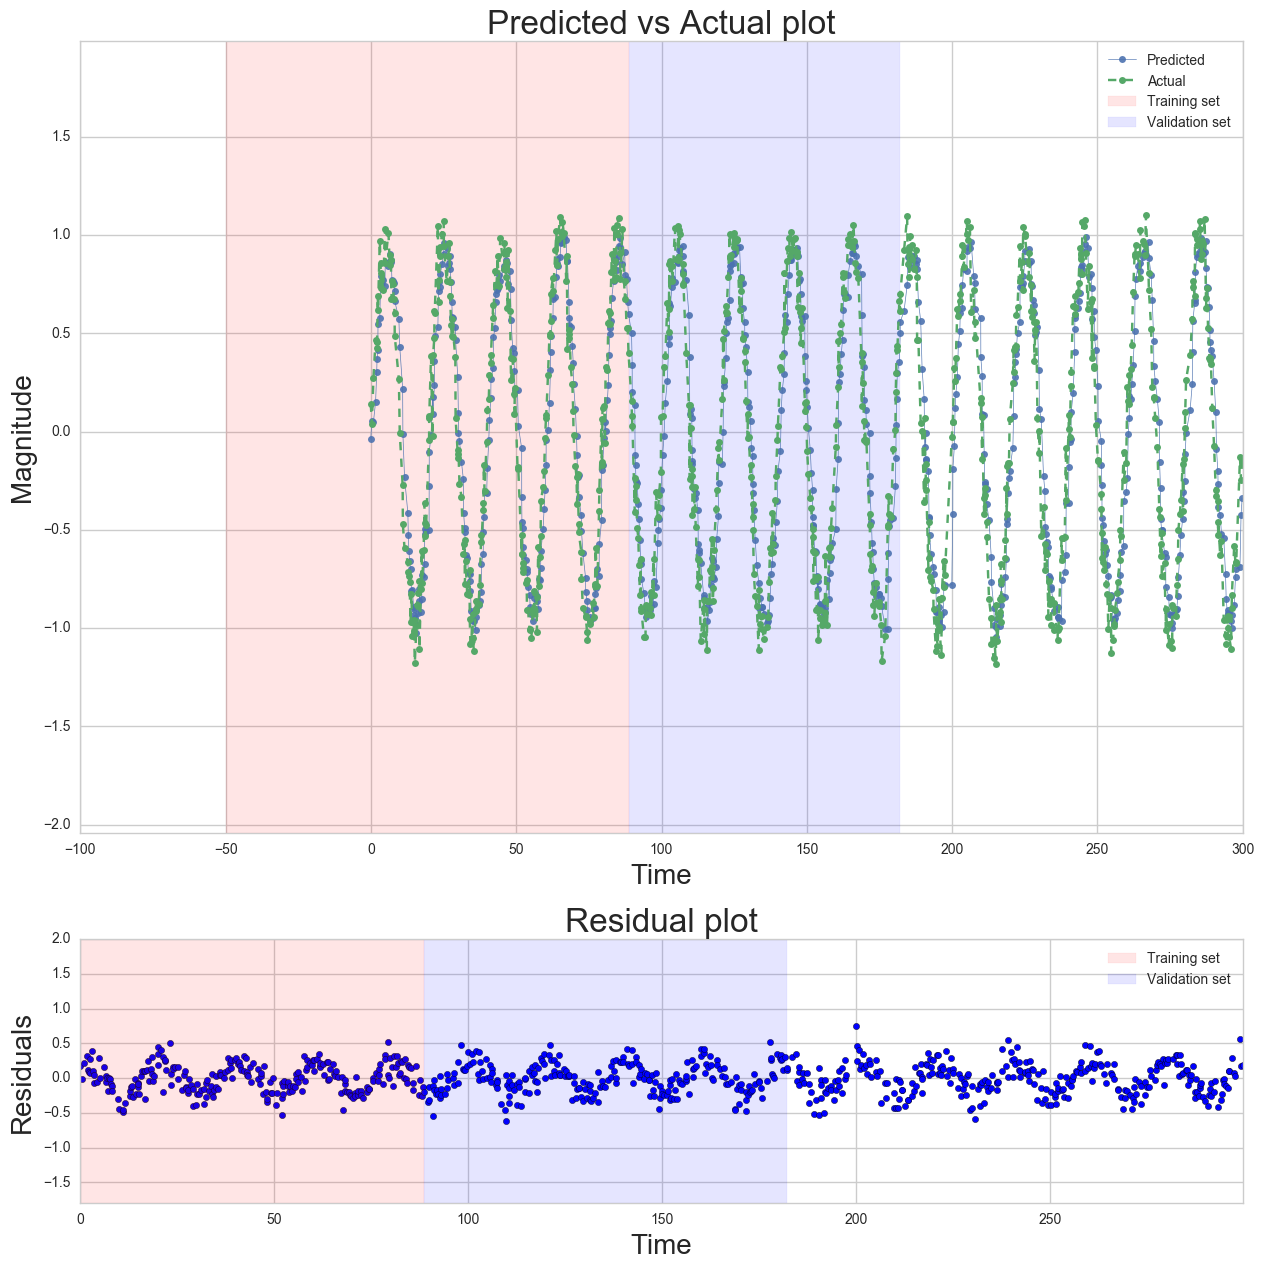

In [10]:
predicted_series = sess.run(outputs,feed_dict={inputs:X})
tflow.utils.plotting.plot_residuals(predicted_series, 
                                    Y, time_vector,
                                    num_training_points, num_validation_points)